# Traffic Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.gridspec as gridspec
import itertools
from sklearn.svm import SVC
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

Using TensorFlow backend.


## Importing Flow Table

In [2]:
df = pd.read_csv("check3.csv")

In [3]:
df.head()

,N_Packets,N_Bytes,Idle_age,Source,Destination,Switch,Traffic,Controller,Duration,time
0,1,42,18,10.0.0.2,10.0.0.6,1,low,6633,18.459,0.459
1,1,42,23,10.0.0.6,10.0.0.2,1,low,6633,23.477,0.477
2,1,42,18,10.0.0.6,10.0.0.2,1,low,6633,18.463,0.463
3,20,1960,4,10.0.0.2,10.0.0.6,1,high,6633,23.470,19.470
4,20,1960,4,10.0.0.6,10.0.0.2,1,high,6633,23.470,19.470


## Preprocessing

In [4]:
lb_make = LabelEncoder()
df['Source'] = lb_make.fit_transform(df['Source'])
df['Destination'] = lb_make.fit_transform(df['Destination'])
# df['Duration'] = lb_make.fit_transform(df['Duration'])
df.loc[df['Traffic']=='low','Traffic'] = 0
df.loc[df['Traffic']=='high','Traffic'] = 1


In [5]:
df.Controller.value_counts()

6633    244
6636    219
6635    214
6634    162
Name: Controller, dtype: int64

In [6]:
df.head()

,N_Packets,N_Bytes,Idle_age,Source,Destination,Switch,Traffic,Controller,Duration,time
0,1,42,18,0,7,1,0,6633,18.459,0.459
1,1,42,23,7,0,1,0,6633,23.477,0.477
2,1,42,18,7,0,1,0,6633,18.463,0.463
3,20,1960,4,0,7,1,1,6633,23.470,19.470
4,20,1960,4,7,0,1,1,6633,23.470,19.470


## Creating test set with 50 instances of each controller

In [7]:
test = df.reset_index(                  # need to keep the index as a column
    ).groupby('Controller'                    # split by "group"
    ).apply(lambda x: x.sample(50,random_state=200) # in each group, do the random split
    ).reset_index(drop=True              # index now is group id - reset it
    ).set_index('index')                 # reset the original index
train = df.drop(test.index) 

In [8]:
test.Controller.value_counts()

6636    50
6635    50
6634    50
6633    50
Name: Controller, dtype: int64

In [9]:
test.groupby('Controller')['Traffic'].value_counts(normalize=True)

Controller  Traffic
6633        0          0.50
            1          0.50
6634        0          0.68
            1          0.32
6635        0          0.62
            1          0.38
6636        0          0.56
            1          0.44
Name: Traffic, dtype: float64

## Data Analysis - Initial Traffic on the Controller 

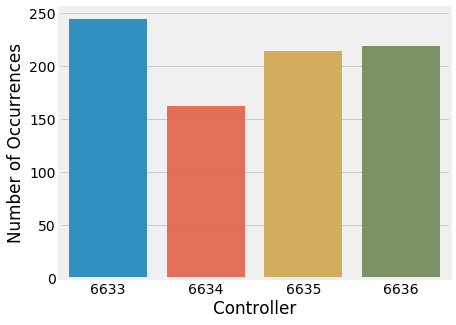

In [10]:
plt.figure(figsize=(7,5))

Controller_count = df['Controller'].value_counts()

#sns.set(style="darkgrid")
plt.style.use('fivethirtyeight')
sns.barplot(Controller_count.index, Controller_count.values, alpha=0.9)

#plt.title('Frequency Distribution of Switch')
plt.ylabel('Number of Occurrences')
plt.xlabel('Controller')
plt.show()

## Preparing Input data and spliting into training and testing

In [11]:
X = df.drop(['Traffic'], axis=1)
y =df['Traffic']

In [12]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train,y_train = train.drop(['Traffic'], axis=1),train['Traffic']
X_test,y_test = test.drop(['Traffic'], axis=1),test['Traffic']

## Feature selection based on importance 

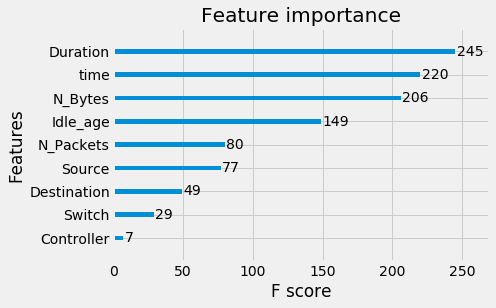

In [13]:
from xgboost import plot_importance
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
# plot feature importance
plot_importance(xgb)
plt.show()

## Generating modified train-test set

In [14]:
X_train_t = X_train.drop(['Controller','Switch','Destination'], axis=1)
X_test_t = X_test.drop(['Controller','Switch','Destination'], axis=1)


from sklearn.preprocessing import StandardScaler
cols = X_train.columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [15]:
X_train.shape,X_test.shape,y_train.shape

((639, 9), (200, 9), (639,))

## Applying a sequential  model

In [16]:
model = Sequential()
model.add(Dense(6, activation = "relu", input_shape=(6, )))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(18, activation = "relu"))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(18, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [17]:
history = model.fit(X_train_t, y_train, epochs=1000,verbose=1,validation_split=0.2,batch_size=40)
score = model.evaluate(X_test_t, y_test, verbose=0)

Train on 511 samples, validate on 128 samples
Epoch 1/1000
511/511 [==============================] - 1s 1ms/step - loss: 48536226.5583 - accuracy: 0.4912 - val_loss: 8.2579 - val_accuracy: 0.5000
Epoch 2/1000
511/511 [==============================] - 0s 104us/step - loss: 11368617.7056 - accuracy: 0.4834 - val_loss: 11.7751 - val_accuracy: 0.5000
Epoch 3/1000
511/511 [==============================] - 0s 106us/step - loss: 3997585.7896 - accuracy: 0.4697 - val_loss: 13.6921 - val_accuracy: 0.5156
Epoch 4/1000
511/511 [==============================] - 0s 104us/step - loss: 4432135.1532 - accuracy: 0.5186 - val_loss: 14.1704 - val_accuracy: 0.5312
Epoch 5/1000
511/511 [==============================] - 0s 102us/step - loss: 3657728.9135 - accuracy: 0.5303 - val_loss: 14.5690 - val_accuracy: 0.5703
Epoch 6/1000
511/511 [==============================] - 0s 102us/step - loss: 53.5988 - accuracy: 0.5421 - val_loss: 15.0105 - val_accuracy: 0.5859
Epoch 7/1000
511/511 [====================

511/511 [==============================] - 0s 94us/step - loss: 58.7011 - accuracy: 0.6027 - val_loss: 9.6378 - val_accuracy: 0.6641
Epoch 56/1000
511/511 [==============================] - 0s 96us/step - loss: 2324129.4937 - accuracy: 0.5969 - val_loss: 9.8513 - val_accuracy: 0.6641
Epoch 57/1000
511/511 [==============================] - 0s 98us/step - loss: 512.4251 - accuracy: 0.5930 - val_loss: 9.9013 - val_accuracy: 0.6641
Epoch 58/1000
511/511 [==============================] - 0s 104us/step - loss: 47.7337 - accuracy: 0.5930 - val_loss: 9.8189 - val_accuracy: 0.6641
Epoch 59/1000
511/511 [==============================] - 0s 100us/step - loss: 57.6023 - accuracy: 0.6125 - val_loss: 9.5782 - val_accuracy: 0.6641
Epoch 60/1000
511/511 [==============================] - 0s 102us/step - loss: 923.4056 - accuracy: 0.6027 - val_loss: 8.8099 - val_accuracy: 0.6641
Epoch 61/1000
511/511 [==============================] - 0s 100us/step - loss: 50.3350 - accuracy: 0.6027 - val_loss: 7.66

511/511 [==============================] - 0s 98us/step - loss: 33.1143 - accuracy: 0.6380 - val_loss: 3.1591 - val_accuracy: 0.7031
Epoch 111/1000
511/511 [==============================] - 0s 96us/step - loss: 43.4088 - accuracy: 0.6477 - val_loss: 3.1179 - val_accuracy: 0.7109
Epoch 112/1000
511/511 [==============================] - 0s 94us/step - loss: 29.2261 - accuracy: 0.6321 - val_loss: 3.0792 - val_accuracy: 0.7109
Epoch 113/1000
511/511 [==============================] - 0s 96us/step - loss: 39.1499 - accuracy: 0.6458 - val_loss: 3.0388 - val_accuracy: 0.7109
Epoch 114/1000
511/511 [==============================] - 0s 92us/step - loss: 29.5066 - accuracy: 0.6477 - val_loss: 3.0000 - val_accuracy: 0.7109
Epoch 115/1000
511/511 [==============================] - 0s 92us/step - loss: 28.0537 - accuracy: 0.6517 - val_loss: 2.9632 - val_accuracy: 0.7109
Epoch 116/1000
511/511 [==============================] - 0s 102us/step - loss: 35.5471 - accuracy: 0.6536 - val_loss: 2.9260 -

511/511 [==============================] - 0s 92us/step - loss: 40.3300 - accuracy: 0.6810 - val_loss: 1.4523 - val_accuracy: 0.7656
Epoch 166/1000
511/511 [==============================] - 0s 98us/step - loss: 31.6450 - accuracy: 0.7025 - val_loss: 1.4299 - val_accuracy: 0.7656
Epoch 167/1000
511/511 [==============================] - 0s 92us/step - loss: 36.0254 - accuracy: 0.6986 - val_loss: 1.4088 - val_accuracy: 0.7656
Epoch 168/1000
511/511 [==============================] - 0s 94us/step - loss: 34.7435 - accuracy: 0.6830 - val_loss: 1.3853 - val_accuracy: 0.7656
Epoch 169/1000
511/511 [==============================] - 0s 90us/step - loss: 25.9212 - accuracy: 0.6908 - val_loss: 1.3643 - val_accuracy: 0.7656
Epoch 170/1000
511/511 [==============================] - 0s 90us/step - loss: 39.0247 - accuracy: 0.7104 - val_loss: 1.3430 - val_accuracy: 0.7656
Epoch 171/1000
511/511 [==============================] - 0s 94us/step - loss: 35.5682 - accuracy: 0.6869 - val_loss: 1.3215 - 

511/511 [==============================] - 0s 96us/step - loss: 38.1089 - accuracy: 0.7299 - val_loss: 0.5773 - val_accuracy: 0.8750
Epoch 221/1000
511/511 [==============================] - 0s 96us/step - loss: 26.3700 - accuracy: 0.7515 - val_loss: 0.5666 - val_accuracy: 0.8750
Epoch 222/1000
511/511 [==============================] - 0s 96us/step - loss: 25.1910 - accuracy: 0.7397 - val_loss: 0.5575 - val_accuracy: 0.8750
Epoch 223/1000
511/511 [==============================] - 0s 94us/step - loss: 32.2462 - accuracy: 0.7319 - val_loss: 0.5475 - val_accuracy: 0.8750
Epoch 224/1000
511/511 [==============================] - 0s 100us/step - loss: 36.2288 - accuracy: 0.7358 - val_loss: 0.5383 - val_accuracy: 0.8750
Epoch 225/1000
511/511 [==============================] - 0s 92us/step - loss: 75.2640 - accuracy: 0.7397 - val_loss: 0.5515 - val_accuracy: 0.8750
Epoch 226/1000
511/511 [==============================] - 0s 94us/step - loss: 40.3510 - accuracy: 0.7143 - val_loss: 0.7026 -

511/511 [==============================] - 0s 106us/step - loss: 30.0774 - accuracy: 0.7436 - val_loss: 0.3103 - val_accuracy: 0.9375
Epoch 276/1000
511/511 [==============================] - 0s 104us/step - loss: 30.8610 - accuracy: 0.7397 - val_loss: 0.3055 - val_accuracy: 0.9375
Epoch 277/1000
511/511 [==============================] - 0s 102us/step - loss: 36.3886 - accuracy: 0.7769 - val_loss: 0.3006 - val_accuracy: 0.9375
Epoch 278/1000
511/511 [==============================] - 0s 94us/step - loss: 31.7762 - accuracy: 0.7476 - val_loss: 0.2959 - val_accuracy: 0.9375
Epoch 279/1000
511/511 [==============================] - 0s 94us/step - loss: 27.5778 - accuracy: 0.7456 - val_loss: 0.2909 - val_accuracy: 0.9453
Epoch 280/1000
511/511 [==============================] - 0s 94us/step - loss: 25.7458 - accuracy: 0.7573 - val_loss: 0.2865 - val_accuracy: 0.9453
Epoch 281/1000
511/511 [==============================] - 0s 109us/step - loss: 36.4856 - accuracy: 0.7613 - val_loss: 0.281

511/511 [==============================] - 0s 94us/step - loss: 31.1638 - accuracy: 0.7769 - val_loss: 0.1904 - val_accuracy: 0.9766
Epoch 331/1000
511/511 [==============================] - 0s 96us/step - loss: 38.0758 - accuracy: 0.7671 - val_loss: 0.1906 - val_accuracy: 0.9766
Epoch 332/1000
511/511 [==============================] - 0s 100us/step - loss: 25.4506 - accuracy: 0.8160 - val_loss: 0.1906 - val_accuracy: 0.9766
Epoch 333/1000
511/511 [==============================] - 0s 98us/step - loss: 31.1334 - accuracy: 0.7906 - val_loss: 0.1909 - val_accuracy: 0.9766
Epoch 334/1000
511/511 [==============================] - 0s 98us/step - loss: 22.8949 - accuracy: 0.7926 - val_loss: 0.1904 - val_accuracy: 0.9766
Epoch 335/1000
511/511 [==============================] - 0s 96us/step - loss: 28.0706 - accuracy: 0.7906 - val_loss: 0.1900 - val_accuracy: 0.9766
Epoch 336/1000
511/511 [==============================] - 0s 92us/step - loss: 31.2193 - accuracy: 0.7945 - val_loss: 0.1908 -

511/511 [==============================] - 0s 104us/step - loss: 37.8294 - accuracy: 0.8004 - val_loss: 0.1753 - val_accuracy: 0.9766
Epoch 386/1000
511/511 [==============================] - 0s 96us/step - loss: 28.0212 - accuracy: 0.7984 - val_loss: 0.1800 - val_accuracy: 0.9766
Epoch 387/1000
511/511 [==============================] - 0s 92us/step - loss: 20.9921 - accuracy: 0.7926 - val_loss: 0.1805 - val_accuracy: 0.9766
Epoch 388/1000
511/511 [==============================] - 0s 94us/step - loss: 31.3688 - accuracy: 0.7808 - val_loss: 0.1809 - val_accuracy: 0.9766
Epoch 389/1000
511/511 [==============================] - 0s 98us/step - loss: 27.2569 - accuracy: 0.7965 - val_loss: 0.1810 - val_accuracy: 0.9766
Epoch 390/1000
511/511 [==============================] - 0s 104us/step - loss: 28.1983 - accuracy: 0.8121 - val_loss: 0.1813 - val_accuracy: 0.9766
Epoch 391/1000
511/511 [==============================] - 0s 100us/step - loss: 31.5851 - accuracy: 0.7710 - val_loss: 0.1818

511/511 [==============================] - 0s 96us/step - loss: 27.6763 - accuracy: 0.8102 - val_loss: 0.1891 - val_accuracy: 0.9766
Epoch 441/1000
511/511 [==============================] - 0s 102us/step - loss: 30.2431 - accuracy: 0.8141 - val_loss: 0.1892 - val_accuracy: 0.9766
Epoch 442/1000
511/511 [==============================] - 0s 104us/step - loss: 25.7832 - accuracy: 0.8258 - val_loss: 0.1852 - val_accuracy: 0.9766
Epoch 443/1000
511/511 [==============================] - 0s 96us/step - loss: 30.5301 - accuracy: 0.8082 - val_loss: 0.1896 - val_accuracy: 0.9766
Epoch 444/1000
511/511 [==============================] - 0s 94us/step - loss: 26.5868 - accuracy: 0.8102 - val_loss: 0.1896 - val_accuracy: 0.9766
Epoch 445/1000
511/511 [==============================] - 0s 94us/step - loss: 32.0260 - accuracy: 0.8200 - val_loss: 0.1895 - val_accuracy: 0.9766
Epoch 446/1000
511/511 [==============================] - 0s 106us/step - loss: 24.9077 - accuracy: 0.8239 - val_loss: 0.1895

511/511 [==============================] - 0s 98us/step - loss: 33.7038 - accuracy: 0.8082 - val_loss: 0.1659 - val_accuracy: 0.9766
Epoch 496/1000
511/511 [==============================] - 0s 100us/step - loss: 30.0833 - accuracy: 0.8023 - val_loss: 0.1669 - val_accuracy: 0.9766
Epoch 497/1000
511/511 [==============================] - 0s 100us/step - loss: 40.5209 - accuracy: 0.8141 - val_loss: 0.1675 - val_accuracy: 0.9766
Epoch 498/1000
511/511 [==============================] - 0s 98us/step - loss: 31.5354 - accuracy: 0.8141 - val_loss: 0.1683 - val_accuracy: 0.9766
Epoch 499/1000
511/511 [==============================] - 0s 98us/step - loss: 27.9101 - accuracy: 0.8004 - val_loss: 0.1692 - val_accuracy: 0.9766
Epoch 500/1000
511/511 [==============================] - 0s 96us/step - loss: 32.2443 - accuracy: 0.8200 - val_loss: 0.1701 - val_accuracy: 0.9766
Epoch 501/1000
511/511 [==============================] - 0s 94us/step - loss: 31.4773 - accuracy: 0.8278 - val_loss: 0.1710 

511/511 [==============================] - 0s 104us/step - loss: 32.4742 - accuracy: 0.8219 - val_loss: 0.2138 - val_accuracy: 0.9766
Epoch 551/1000
511/511 [==============================] - 0s 92us/step - loss: 32.7479 - accuracy: 0.8356 - val_loss: 0.2139 - val_accuracy: 0.9766
Epoch 552/1000
511/511 [==============================] - 0s 94us/step - loss: 37.4316 - accuracy: 0.8395 - val_loss: 0.2142 - val_accuracy: 0.9766
Epoch 553/1000
511/511 [==============================] - 0s 92us/step - loss: 39.6485 - accuracy: 0.8376 - val_loss: 0.2145 - val_accuracy: 0.9766
Epoch 554/1000
511/511 [==============================] - 0s 100us/step - loss: 25.1477 - accuracy: 0.8395 - val_loss: 0.2144 - val_accuracy: 0.9766
Epoch 555/1000
511/511 [==============================] - 0s 98us/step - loss: 38.6522 - accuracy: 0.8219 - val_loss: 0.2139 - val_accuracy: 0.9766
Epoch 556/1000
511/511 [==============================] - 0s 106us/step - loss: 24.5824 - accuracy: 0.8434 - val_loss: 0.2113

511/511 [==============================] - 0s 104us/step - loss: 31.4052 - accuracy: 0.8591 - val_loss: 0.2392 - val_accuracy: 0.9766
Epoch 606/1000
511/511 [==============================] - 0s 104us/step - loss: 32.6529 - accuracy: 0.8474 - val_loss: 0.2399 - val_accuracy: 0.9766
Epoch 607/1000
511/511 [==============================] - 0s 96us/step - loss: 31.4264 - accuracy: 0.8376 - val_loss: 0.2409 - val_accuracy: 0.9766
Epoch 608/1000
511/511 [==============================] - 0s 96us/step - loss: 27.3382 - accuracy: 0.8434 - val_loss: 0.2416 - val_accuracy: 0.9766
Epoch 609/1000
511/511 [==============================] - 0s 98us/step - loss: 20.0803 - accuracy: 0.8571 - val_loss: 0.2422 - val_accuracy: 0.9766
Epoch 610/1000
511/511 [==============================] - 0s 98us/step - loss: 26.6655 - accuracy: 0.8454 - val_loss: 0.2419 - val_accuracy: 0.9766
Epoch 611/1000
511/511 [==============================] - 0s 90us/step - loss: 31.5432 - accuracy: 0.8415 - val_loss: 0.2424 

511/511 [==============================] - 0s 98us/step - loss: 45795.3843 - accuracy: 0.8591 - val_loss: 0.2118 - val_accuracy: 0.9766
Epoch 661/1000
511/511 [==============================] - 0s 98us/step - loss: 55.3735 - accuracy: 0.8160 - val_loss: 0.1595 - val_accuracy: 0.9766
Epoch 662/1000
511/511 [==============================] - 0s 106us/step - loss: 77.9925 - accuracy: 0.7984 - val_loss: 0.1604 - val_accuracy: 0.9766
Epoch 663/1000
511/511 [==============================] - 0s 98us/step - loss: 44.8211 - accuracy: 0.7789 - val_loss: 0.1595 - val_accuracy: 0.9766
Epoch 664/1000
511/511 [==============================] - 0s 94us/step - loss: 81.0096 - accuracy: 0.8063 - val_loss: 0.1617 - val_accuracy: 0.9766
Epoch 665/1000
511/511 [==============================] - 0s 100us/step - loss: 61.4027 - accuracy: 0.7906 - val_loss: 0.1648 - val_accuracy: 0.9766
Epoch 666/1000
511/511 [==============================] - 0s 102us/step - loss: 1900636.7200 - accuracy: 0.7886 - val_loss

511/511 [==============================] - 0s 104us/step - loss: 73.0572 - accuracy: 0.7945 - val_loss: 0.2321 - val_accuracy: 0.9766
Epoch 716/1000
511/511 [==============================] - 0s 98us/step - loss: 55.7779 - accuracy: 0.8043 - val_loss: 0.2316 - val_accuracy: 0.9766
Epoch 717/1000
511/511 [==============================] - 0s 96us/step - loss: 72.0079 - accuracy: 0.8180 - val_loss: 0.2313 - val_accuracy: 0.9766
Epoch 718/1000
511/511 [==============================] - 0s 102us/step - loss: 64.2565 - accuracy: 0.8160 - val_loss: 0.2308 - val_accuracy: 0.9766
Epoch 719/1000
511/511 [==============================] - 0s 109us/step - loss: 53.2301 - accuracy: 0.8082 - val_loss: 0.2304 - val_accuracy: 0.9766
Epoch 720/1000
511/511 [==============================] - 0s 100us/step - loss: 49.6809 - accuracy: 0.7945 - val_loss: 0.2295 - val_accuracy: 0.9766
Epoch 721/1000
511/511 [==============================] - 0s 100us/step - loss: 64.7389 - accuracy: 0.7926 - val_loss: 0.22

511/511 [==============================] - 0s 94us/step - loss: 55.1154 - accuracy: 0.8200 - val_loss: 0.1464 - val_accuracy: 0.9766
Epoch 771/1000
511/511 [==============================] - 0s 96us/step - loss: 69.3203 - accuracy: 0.8219 - val_loss: 0.1554 - val_accuracy: 0.9766
Epoch 772/1000
511/511 [==============================] - 0s 96us/step - loss: 69.6851 - accuracy: 0.8063 - val_loss: 0.1559 - val_accuracy: 0.9766
Epoch 773/1000
511/511 [==============================] - 0s 100us/step - loss: 42.2269 - accuracy: 0.8239 - val_loss: 0.1550 - val_accuracy: 0.9766
Epoch 774/1000
511/511 [==============================] - 0s 104us/step - loss: 45.4776 - accuracy: 0.8043 - val_loss: 0.1520 - val_accuracy: 0.9766
Epoch 775/1000
511/511 [==============================] - 0s 100us/step - loss: 42.5847 - accuracy: 0.8200 - val_loss: 0.1483 - val_accuracy: 0.9766
Epoch 776/1000
511/511 [==============================] - 0s 100us/step - loss: 45.2417 - accuracy: 0.8317 - val_loss: 0.149

511/511 [==============================] - 0s 96us/step - loss: 60.8456 - accuracy: 0.8239 - val_loss: 0.1050 - val_accuracy: 0.9766
Epoch 826/1000
511/511 [==============================] - 0s 98us/step - loss: 61.8514 - accuracy: 0.8356 - val_loss: 0.1050 - val_accuracy: 0.9766
Epoch 827/1000
511/511 [==============================] - 0s 94us/step - loss: 60.3924 - accuracy: 0.8180 - val_loss: 0.1059 - val_accuracy: 0.9766
Epoch 828/1000
511/511 [==============================] - 0s 98us/step - loss: 56.0853 - accuracy: 0.8160 - val_loss: 0.1064 - val_accuracy: 0.9766
Epoch 829/1000
511/511 [==============================] - 0s 106us/step - loss: 52.2882 - accuracy: 0.8513 - val_loss: 0.1064 - val_accuracy: 0.9766
Epoch 830/1000
511/511 [==============================] - 0s 102us/step - loss: 65.6698 - accuracy: 0.8317 - val_loss: 0.1062 - val_accuracy: 0.9766
Epoch 831/1000
511/511 [==============================] - 0s 100us/step - loss: 60.6099 - accuracy: 0.8317 - val_loss: 0.1056

511/511 [==============================] - 0s 100us/step - loss: 57.6894 - accuracy: 0.8239 - val_loss: 0.1099 - val_accuracy: 0.9766
Epoch 881/1000
511/511 [==============================] - 0s 100us/step - loss: 53.2034 - accuracy: 0.8337 - val_loss: 0.1098 - val_accuracy: 0.9766
Epoch 882/1000
511/511 [==============================] - 0s 98us/step - loss: 51.4316 - accuracy: 0.8180 - val_loss: 0.1095 - val_accuracy: 0.9766
Epoch 883/1000
511/511 [==============================] - 0s 98us/step - loss: 40.0687 - accuracy: 0.8415 - val_loss: 0.1095 - val_accuracy: 0.9766
Epoch 884/1000
511/511 [==============================] - 0s 98us/step - loss: 61.7081 - accuracy: 0.8337 - val_loss: 0.1094 - val_accuracy: 0.9766
Epoch 885/1000
511/511 [==============================] - 0s 100us/step - loss: 47.9381 - accuracy: 0.8337 - val_loss: 0.1093 - val_accuracy: 0.9766
Epoch 886/1000
511/511 [==============================] - 0s 98us/step - loss: 41.4664 - accuracy: 0.8278 - val_loss: 0.1094

511/511 [==============================] - 0s 106us/step - loss: 52.2990 - accuracy: 0.8141 - val_loss: 0.1112 - val_accuracy: 0.9766
Epoch 936/1000
511/511 [==============================] - 0s 98us/step - loss: 78.2068 - accuracy: 0.8082 - val_loss: 0.1111 - val_accuracy: 0.9766
Epoch 937/1000
511/511 [==============================] - 0s 94us/step - loss: 74.0878 - accuracy: 0.8180 - val_loss: 0.1110 - val_accuracy: 0.9766
Epoch 938/1000
511/511 [==============================] - 0s 90us/step - loss: 80.0505 - accuracy: 0.8082 - val_loss: 0.1113 - val_accuracy: 0.9766
Epoch 939/1000
511/511 [==============================] - 0s 98us/step - loss: 77.6410 - accuracy: 0.8219 - val_loss: 0.1115 - val_accuracy: 0.9766
Epoch 940/1000
511/511 [==============================] - 0s 104us/step - loss: 50.8258 - accuracy: 0.8356 - val_loss: 0.1117 - val_accuracy: 0.9766
Epoch 941/1000
511/511 [==============================] - 0s 104us/step - loss: 69.5772 - accuracy: 0.8082 - val_loss: 0.1121

511/511 [==============================] - 0s 100us/step - loss: 77.1080 - accuracy: 0.8415 - val_loss: 0.1163 - val_accuracy: 0.9766
Epoch 991/1000
511/511 [==============================] - 0s 98us/step - loss: 76.0089 - accuracy: 0.8082 - val_loss: 0.1163 - val_accuracy: 0.9766
Epoch 992/1000
511/511 [==============================] - 0s 104us/step - loss: 74.2390 - accuracy: 0.8317 - val_loss: 0.1161 - val_accuracy: 0.9766
Epoch 993/1000
511/511 [==============================] - 0s 98us/step - loss: 68.1697 - accuracy: 0.8239 - val_loss: 0.1162 - val_accuracy: 0.9766
Epoch 994/1000
511/511 [==============================] - 0s 100us/step - loss: 67.5483 - accuracy: 0.8258 - val_loss: 0.1162 - val_accuracy: 0.9766
Epoch 995/1000
511/511 [==============================] - 0s 100us/step - loss: 72.0339 - accuracy: 0.8239 - val_loss: 0.1162 - val_accuracy: 0.9766
Epoch 996/1000
511/511 [==============================] - 0s 102us/step - loss: 67.3682 - accuracy: 0.8258 - val_loss: 0.11

## Test loss and accuracy

In [18]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 9.402446506228298
Test accuracy: 0.925000011920929


## Plotting graphs - loss and accuracy

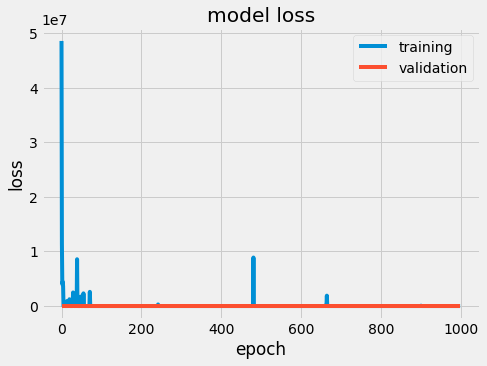

In [19]:
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [20]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

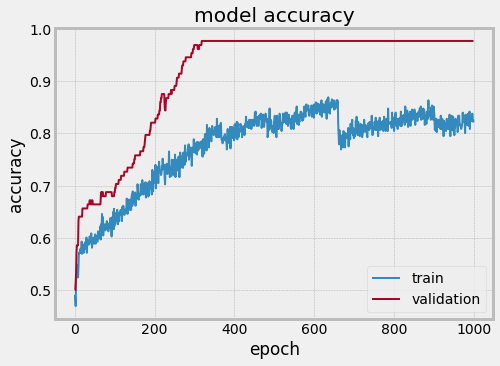

In [21]:
plt.figure(figsize=(7,5))
plt.style.use('bmh')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# Future Traffic Prediction - load on the controller - based on Neural Network

In [22]:
prediction = model.predict_classes(X_test_t)

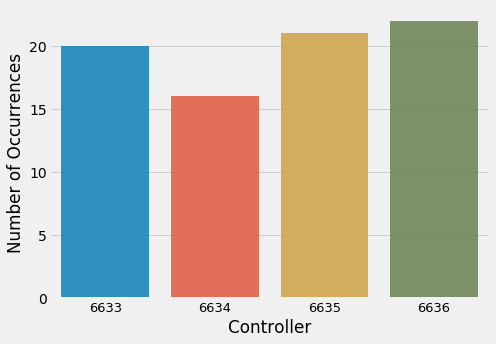

In [23]:
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')
Controller_count = pd.DataFrame(list(zip(X_test['Controller'],prediction[:,0]))).groupby(0)[1].value_counts()[:,1]
#sns.set(style="darkgrid")
ax = sns.barplot(Controller_count.index, Controller_count.values, alpha=0.9)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
#plt.title('Frequency Distribution of Switch')
plt.ylabel('Number of Occurrences')
plt.xlabel('Controller')
plt.show()

In [24]:
pd.DataFrame(list(zip(X_test['Controller'],prediction[:,0]))).groupby(0)[1].value_counts()[:,1]

0
6633    20
6634    16
6635    21
6636    22
Name: 1, dtype: int64

## Confusion Matrix 0 - low 1 - high

C:\Users\u_kan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


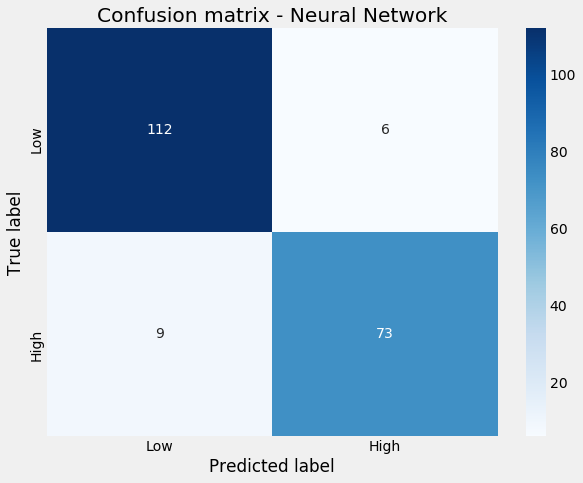

In [25]:
classes=['Low','High']
plt.figure(figsize=(9,7))
plt.title('Confusion matrix - Neural Network')
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test.astype(int),prediction[:,0]),annot=True,fmt='d',cmap="Blues") 
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [26]:
def create_model():
    model = Sequential()
    model.add(Dense(6, activation = "relu", input_shape=(6, )))
    model.add(Dropout(0.2, noise_shape=None, seed=None))
    model.add(Dense(18, activation = "relu"))
    model.add(Dropout(0.2, noise_shape=None, seed=None))
    model.add(Dense(18, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Performing 5-Fold Cross Validation and and comparing various algorithms

In [28]:
import warnings
warnings.filterwarnings("ignore")

xgb = XGBClassifier()
rf = RandomForestClassifier(n_estimators=200)
logreg= LogisticRegressionCV(solver='lbfgs', cv=10,max_iter=500)
nclf = KerasClassifier(create_model, epochs=1000,validation_split=0.2,batch_size=40,verbose=0)
svc = SVC(C = 1,random_state=20)

# est_AB = AdaBoostClassifier()
# score_AB=est_AB.fit(X_train,y_train).score(X_test,y_test)

# est_RF = RandomForestClassifier()
# score_RF=est_RF.fit(X_train,y_train).score(X_test,y_test)

# est_Ensemble = EnsembleVotingClassifier(estimators=[('XGB', xgb), ('RF', rf),('NN', nclf)],voting='hard')
est_Ensemble = EnsembleVoteClassifier(clfs=[xgb, rf, logreg,nclf], weights=[1, 1, 1, 0.8], voting='soft')

results = []
names = []
print("Accuracy and Standard deviation of various algorithms:")

for clf, label in zip([xgb, rf,logreg, svc,nclf, est_Ensemble], [
    'XGB Classifier',
    'Random Forest', 
    'Logistic Regression',
    'SVM',
    'Neural Network',
    'Ensemble']):
    
    scores = cross_val_score(clf, X_train_t, y_train, cv=5, scoring='accuracy')
    results.append(scores)
    names.append(label)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))    
    # boxplot algorithm comparison
# plt.rcParams['figure.figsize'] = [15, 8]              
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()
# score_Ensemble=est_Ensemble.fit(X_train,y_train).score(X_test,y_test)

Accuracy and Standard deviation of various algorithms:
Accuracy: 0.89 (+/- 0.07) [XGB Classifier]
Accuracy: 0.90 (+/- 0.06) [Random Forest]
Accuracy: 0.89 (+/- 0.08) [Logistic Regression]
Accuracy: 0.63 (+/- 0.01) [SVM]
Accuracy: 0.85 (+/- 0.13) [Neural Network]
Accuracy: 0.90 (+/- 0.07) [Ensemble]


## Boxplot -  Algorithm Comparison Chart

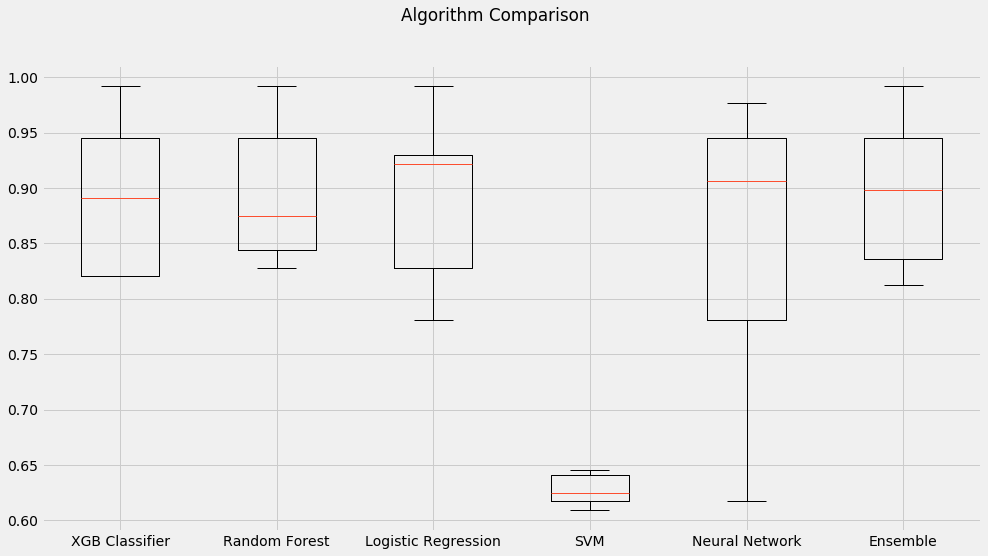

In [29]:
plt.rcParams['figure.figsize'] = [15, 8]              
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Plotting decision boundaries of various classifiers

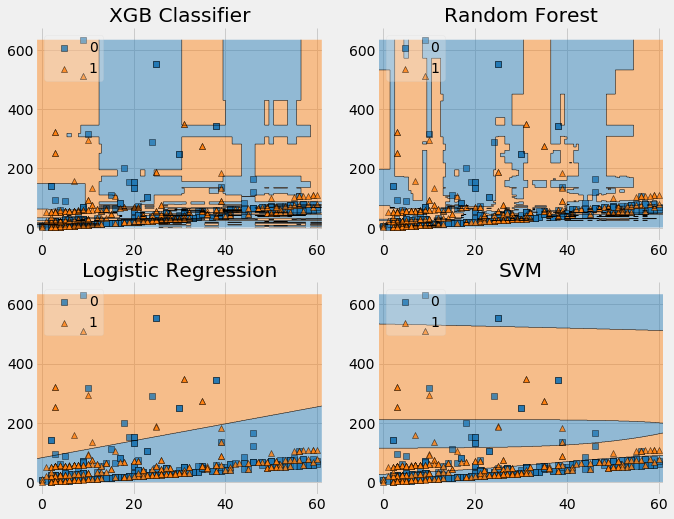

In [30]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for clf, label, grd  in zip([xgb, rf, logreg, svc], [
    'XGB Classifier',
    'Random Forest', 
    'Logistic Regression',
    'SVM'],
    itertools.product([0, 1], repeat=2)):
    
    clf.fit(X_train_t.values[:,[2,4]], y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_t.values[:,[2,4]], y=y_train.values,
                                clf=clf, legend=2)
    plt.title(label)

plt.show()

In [31]:
# est_Ensemble.fit(X_train_t,y_train)
# # est_Ensemble.predict(X_test_t)
# est_Ensemble.score(X_test_t,y_test)

In [32]:
# logreg= LogisticRegressionCV(solver='lbfgs', cv=10,max_iter=500)
# logreg.fit(X_train_t,y_train)
# logreg.score(X_test_t,y_test)

## Confusion Matrices of various classifiers

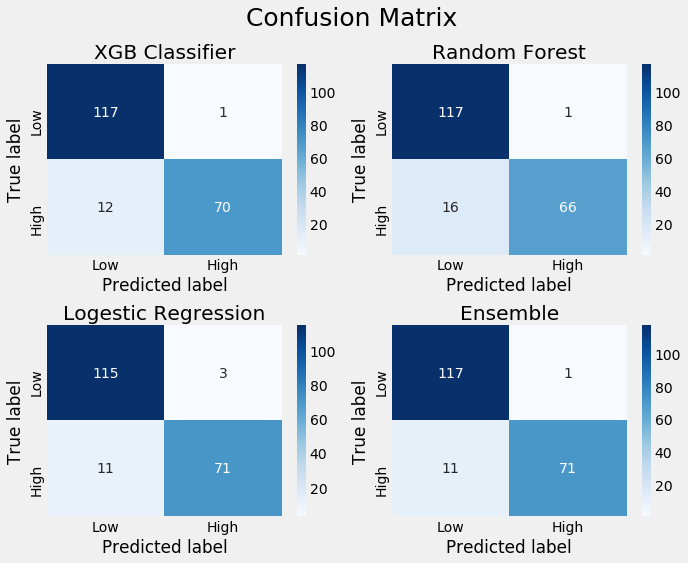

In [33]:
from sklearn.metrics import plot_confusion_matrix
classes=['Low','High']
plt.style.use('bmh')
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))
# plt.title('Confusion Matrix')
for clf, label, grd  in zip([xgb, rf, logreg, est_Ensemble], [
    'XGB Classifier',
    'Random Forest', 
    'Logestic Regression',
    'Ensemble'],
    itertools.product([0, 1], repeat=2)):
    clf.fit(X_train_t, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    plt.tight_layout()
    sns.heatmap(confusion_matrix(y_test,clf.predict(X_test_t)),annot=True,fmt='d',cmap="Blues") 
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(label)
plt.suptitle('Confusion Matrix',fontsize=25)
plt.subplots_adjust(top=0.88)
plt.show()

## Prediction using Ensemble Model

In [34]:
est_Ensemble.fit(X_train_t,y_train)

EnsembleVoteClassifier(clfs=[XGBClassifier(base_score=0.5, booster=None,
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=0,
                                           num_parallel_...
                             LogisticRegressionCV(Cs=10, class_weight=None,
                                                  cv=10, dual=False,
           

In [35]:
prediction = est_Ensemble.predict(X_test_t)

## Future Traffic Prediction - load on the controller - based on Ensemble Model

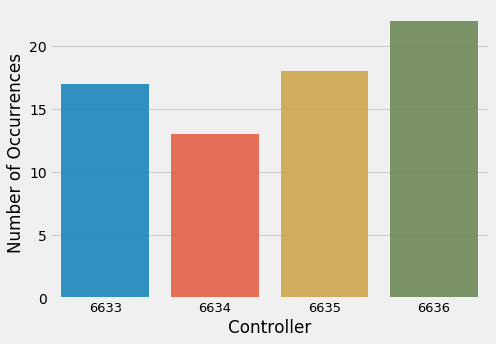

In [36]:
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')
Controller_count = pd.DataFrame(list(zip(X_test['Controller'],prediction))).groupby(0)[1].value_counts()[:,1]
#sns.set(style="darkgrid")
ax = sns.barplot(Controller_count.index, Controller_count.values, alpha=0.9)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
#plt.title('Frequency Distribution of Switch')
plt.ylabel('Number of Occurrences')
plt.xlabel('Controller')
plt.show()

In [37]:
pd.DataFrame(list(zip(X_test['Controller'],prediction))).groupby(0)[1].value_counts()[:,1]

0
6633    17
6634    13
6635    18
6636    22
Name: 1, dtype: int64

## Classification Report - Ensemble Model

In [38]:
print(classification_report(y_test,prediction,target_names=classes))

              precision    recall  f1-score   support

         Low       0.90      0.99      0.94       118
        High       0.99      0.84      0.91        82

    accuracy                           0.93       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.94      0.93      0.93       200

